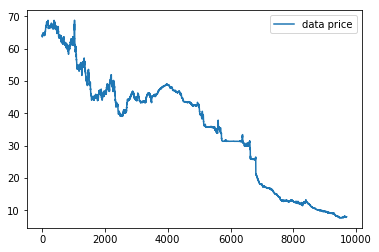

In [165]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
data_path = 'data/financial_data/USD_INR.csv'
data = pd.read_csv(data_path)

# # Data: cleaning
# # Getting rid of NaN
# data = data.fillna(value=0.0)

# # # # Plotting the smartwatch data before scaling/batch normalization
# data[:10000]['Price'].plot() #x='dteday', y='cnt'
# # data[:10000].plot()

# # # data[:100].plot()
# np.array(data).shape, np.array(data).dtype, np.array(data, dtype=None).dtype, 
# np.array(data[:, 1:], dtype=None).dtype

data_price = np.array(data['Price'], dtype=float)
# data_price = np.array(data)
data_price.shape, data_price.dtype

plt.plot(data_price, label='data price')
plt.legend()
plt.show()

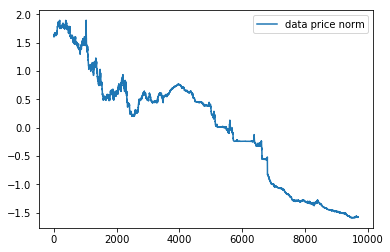

In [166]:
# test_data = np.array([[1, 2, 3]], dtype=float)
# test_data.shape, test_data.dtype
# np.mean(test_data, axis=0), test_data

# data_ = np.array(data[:, 1], dtype=float)
# data_.shape, data_.dtype
data_mean = np.mean(data_price, axis=0)
data_std = np.std(data_price, axis=0)
# std, mean, np.sqrt(np.var(data_price))
data_norm = (data_price - mean) / std
data_norm.dtype, data_norm.shape

plt.plot(data_norm, label='data price norm')
# plt.plot(data_price[:10000], label='data price')
plt.legend()
plt.show()

(4.6895674011185329e-17, 1.0, 1.0)

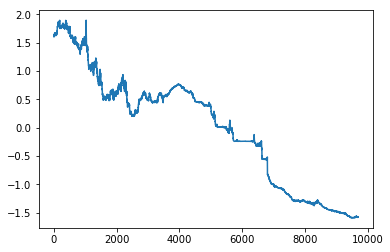

In [167]:
data_price_norm = (data_price - data_price.mean(axis=0)) / data_price.std(axis=0)
plt.plot(data_price_norm)
data_price_norm.mean(axis=0), data_price_norm.std(), data_price_norm.var()

In [168]:
train_data = data_price_norm[:9000]
test_data = data_price_norm[9000:]
train_data.shape, test_data.shape
X_train = train_data[:8999]
Y_train = train_data[1:9000]
X_train.shape, Y_train.shape
X_valid = test_data[:600] # 600 samples
Y_valid = test_data[1:601] # 600 samples
X_valid.shape, Y_valid.shape

((600,), (600,))

In [169]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m, train): # This can be used for training & testing
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        if train: # is True
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, do_cache)
        else:
            cache = None

        return y, h, cache

    def backward(self, dy, dh, cache): # This is only used for training
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, do_cache = cache
        
        dh_out = dh.copy()

        dy = l.dropout_backward(dy, do_cache)
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X = X.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
                    
        return ys, caches
    
    def loss_function(self, y_pred, y_train):
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression(y_pred=y, y_train=Y) #/ m: t or number of samples for taking the average
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})

        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
                
        return grads
    
    def test(self, X_seed, h, size):
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
            ys.append(y)
            
        return ys

In [170]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

#     for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, XY_valid, normalizing_data, alpha, mb_size, n_iter, print_after):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid
    mean, std = normalizing_data
    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            # def loss_function(self, y_pred, y_train):
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini)
            grads = nn.train_backward(dys, caches)            
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)
                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))
                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Validation loss to avoid overfitting & underfitting
        # for idx in range(len(minibatches)):
#         idx = len(minibatches)//2
#         X_mini, y_mini = minibatches[idx]
        # Prediction or predicted sequence
        ys = nn.test(X_seed=X_valid[0], h=state, size=X_valid.shape[0]) # ys_tx1xn
        y_pred = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn
        ys_ = mean + (std * y_pred)
        ys = ys.reshape(ys_.shape(0), 1, ys_.shape(1)) # ys_denorm_tx1xn
        valid_loss, _ = nn.loss_function(y_pred=ys, y_train=Y_valid)
        nn.losses['valid'].append(valid_loss)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.4f}, valid loss: {:.4f}'.format(iter, loss, valid_loss))

    return nn

In [ ]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 100 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = 1 # X_train.shape[1] #len(char_to_idx) # vocab_size = len(char_to_idx)
p_dropout = 0.95 # dropout = 1- keep_prob, p = 1-q

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, p_dropout=p_dropout) #, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=(X_train, Y_train), XY_valid=(X_valid, Y_valid), normalizing_data=(data_mean, data_std), 
         alpha=alpha, 
         mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

In [207]:
np.random.binomial(1, 0.95, size=X_train.shape[1]) # / p_dropout

array([1, 1, 1, 1, 1])

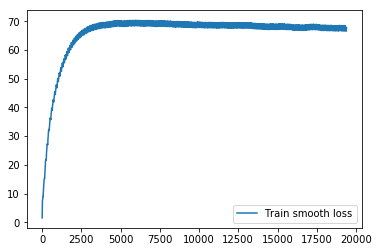

In [120]:
plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

In [40]:
ys = net.test(h=net.initial_state(),size=1000,X_seed=X_train[1000])
np.array(ys).shape

(1000, 1, 2)

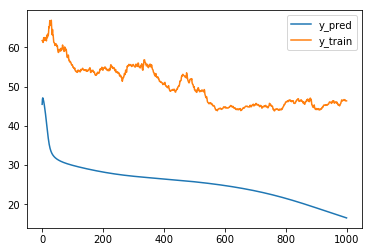

In [41]:
y_pred = np.array(ys).reshape(len(ys), -1)
plt.plot(y_pred[:, 0], label='y_pred')
plt.plot(y_train[1000:2000, 0], label='y_train')
plt.legend()
plt.show()